In [1]:
%load_ext autoreload
%autoreload 2

from multicamera_acquisition.acquisition import refactor_acquire_video, AcquisitionLoop
from multicamera_acquisition.writer import NVC_Writer, FFMPEG_Writer
from multicamera_acquisition.interfaces.microcontroller import Microcontroller 
from multicamera_acquisition.visualization import MultiDisplay
from multicamera_acquisition.interfaces.config import (
    partial_config_from_camera_list,
    create_full_camera_default_config,
)


In [2]:
# Run the func!
import logging

def reset_loggers():
    # Remove handlers from all loggers
    for logger in logging.Logger.manager.loggerDict.values():
        if isinstance(logger, logging.Logger):  # Guard against 'PlaceHolder' objects
            logger.handlers.clear()

    # Reset the root logger
    logging.getLogger().handlers.clear()

In [3]:
camera_list = [
    {"name": "side3",  "brand": "basler", "id": "40332773", "gain": 25, "exposure": 1000},
    {"name": "side4",  "brand": "basler", "id": "40347935", "gain": 25, "exposure": 1000},
    {"name": "side2",  "brand": "basler", "id": "40347941", "gain": 25, "exposure": 1000},
    {"name": "side1",  "brand": "basler", "id": "40347943", "gain": 26, "exposure": 1000, "roi": (0,96,1920,1104)},
    {"name": "top",    "brand": "basler", "id": "40393557", "gain": 25, "exposure": 1000, "roi": (128,0,1440,1200)},
    {"name": "bottom", "brand": "basler", "id": "40393560", "gain": 22, "exposure": 1000, "roi": (448,0,1248,1200)},
    {"name": "azure_top",    "brand": "azure", "id": "000500221712", "subordinate_delay_off_master_usec": 160},
    {"name": "azure_bottom", "brand": "azure", "id": "000693321712", "subordinate_delay_off_master_usec": 0},    
]

# Set the trigger behavior
for camera in camera_list[:6]:
    camera["trigger_type"] = "microcontroller"

# Recording params
fps = 120
tmp_path = R'D:\Jonah\2023_12_26_6cam_testing\tmp'
logging_level = "INFO"

In [4]:
# Parse the "camera list" into a partial config
partial_new_config = partial_config_from_camera_list(camera_list)

# Add writer configs to each ir camera config
for camera_name in partial_new_config["cameras"].keys():
    if partial_new_config["cameras"][camera_name]["brand"] != "basler":
        continue
    ir_writer_config = NVC_Writer.default_writer_config(fps).copy()
    ir_writer_config["camera_name"] = camera_name
    partial_new_config["cameras"][camera_name]["writer"] = ir_writer_config

# Add writer config for the azure cameras
for camera_name in partial_new_config["cameras"].keys():
    if partial_new_config["cameras"][camera_name]["brand"] != "azure":
        continue
    az_ir_config = FFMPEG_Writer.default_writer_config(30, vid_type="ir", gpu=None).copy()
    az_dp_config = FFMPEG_Writer.default_writer_config(30, vid_type="depth", gpu=None).copy()
    az_ir_config["camera_name"] = camera_name
    az_dp_config["camera_name"] = camera_name
    partial_new_config["cameras"][camera_name]["writer"] = az_ir_config
    partial_new_config["cameras"][camera_name]["writer_depth"] = az_dp_config



In [5]:
# Create the full config, filling in defaults where necessary
full_config = create_full_camera_default_config(partial_new_config, fps)
full_config["globals"] = {}
full_config["globals"]["fps"] = fps
full_config["globals"]["microcontroller_required"] =True

# Set up the acquisition loop part of the config
acq_config = AcquisitionLoop.default_acq_loop_config().copy()
full_config["acq_loop"] = acq_config

# Set up the Microcontroller part of the config
full_config["microcontroller"] = Microcontroller.default_microcontroller_config()
full_config["microcontroller"]["top_camera_pins"] = [1, 5, 7, 9, 11, 33]  # 33 is a "fictive camera" for syncing
full_config["microcontroller"]["top_light_pins"] = [38, 39, 40, 41]
full_config["microcontroller"]["bottom_camera_pins"] = [3]
full_config["microcontroller"]["bottom_light_pins"] = [14, 15, 16, 17]
full_config["microcontroller"]["random_output_pins"] = [34]  # also 35?
full_config["microcontroller"]["input_pins"] = [] 

full_config["rt_display"] = MultiDisplay.default_MultiDisplay_config()

In [6]:
logging_level = "INFO"

In [7]:
rec_time_s = 20

2024-01-23 22:31:55,911 - main_acq_logger - INFO - Finding microcontroller...
2024-01-23 22:31:56,192 - main_acq_logger - INFO - Found ready microcontroller on port: COM3
2024-01-23 22:31:56,192 - main_acq_logger - INFO - Opening subprocesses and cameras, this may take a moment...
2024-01-23 22:32:06,549 - main_acq_logger - INFO - Starting cameras...
2024-01-23 22:32:07,440 - main_acq_logger - INFO - Starting microcontroller...


Recording Progress: 10.0%

2024-01-23 22:32:28,187 - side3_acqLoop - INFO - Acq loop for side3 is finished.
2024-01-23 22:32:28,272 - side4_acqLoop - INFO - Acq loop for side4 is finished.
2024-01-23 22:32:28,343 - side2_acqLoop - INFO - Acq loop for side2 is finished.
2024-01-23 22:32:28,426 - side1_acqLoop - INFO - Acq loop for side1 is finished.
2024-01-23 22:32:28,503 - top_acqLoop - INFO - Acq loop for top is finished.
2024-01-23 22:32:28,603 - bottom_acqLoop - INFO - Acq loop for bottom is finished.
2024-01-23 22:32:28,988 - azure_top_acqLoop - INFO - Acq loop for azure_top is finished.
2024-01-23 22:32:29,365 - azure_bottom_acqLoop - INFO - Acq loop for azure_bottom is finished.
2024-01-23 22:32:29,424 - main_acq_logger - INFO - Ending processes, this may take a moment...
2024-01-23 22:32:29,424 - main_acq_logger - INFO - Done.


Recording Progress: 100%

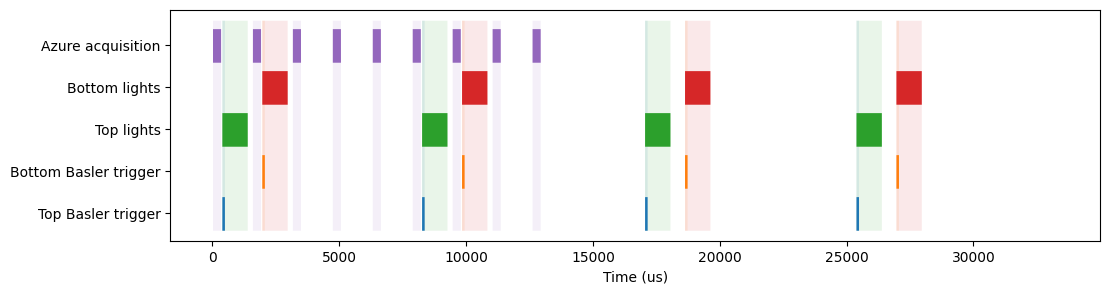

In [8]:
reset_loggers()

save_loc, first_video_file_name, full_config = refactor_acquire_video(
    tmp_path,
    full_config,
    recording_duration_s=rec_time_s,
    append_datetime=True,
    overwrite=False,
    logging_level=logging_level
)

In [9]:
from pathlib2 import Path
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.set_loglevel (level = 'warning')

In [10]:
# save_loc = R"D:\Jonah\2023_12_26_6cam_testing\tmp\90hz"

side3


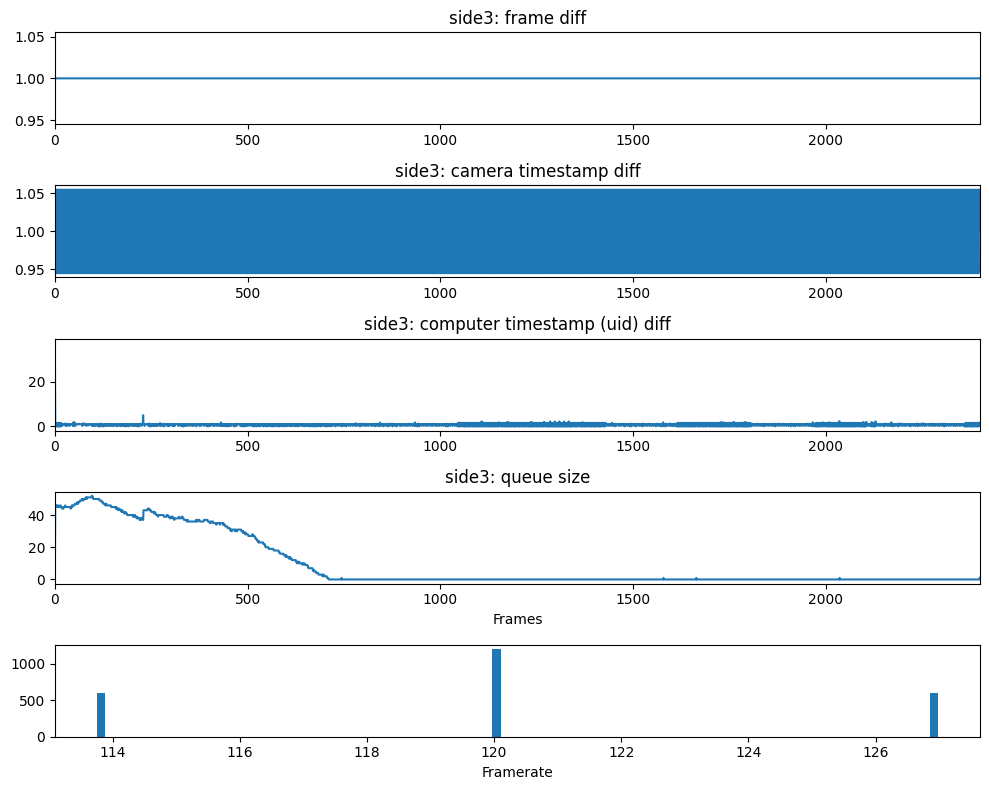

19.99188455
119.99869216931826
side4


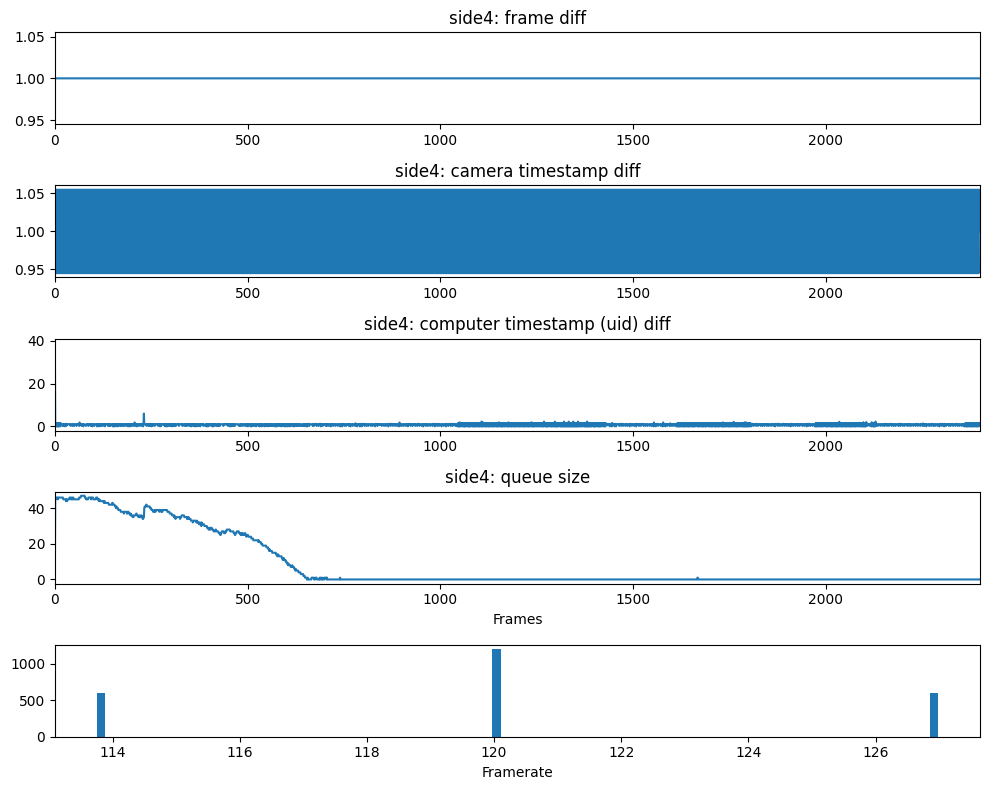

19.991913920000002
119.99851587996432
side2


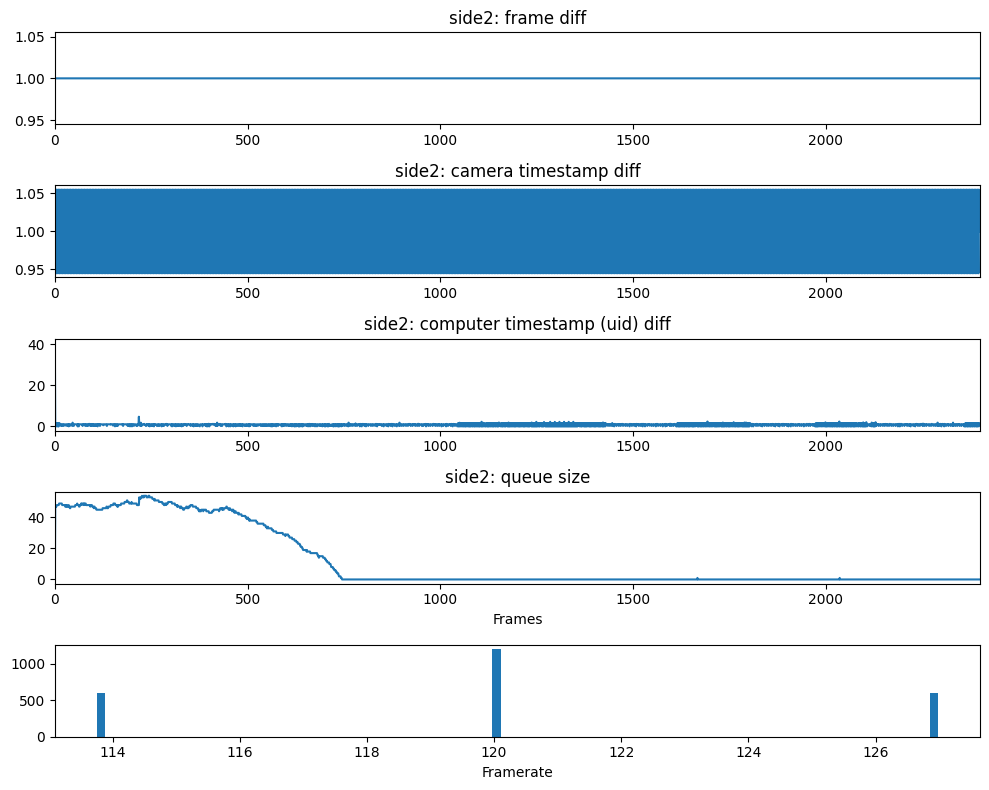

19.99194504
119.99832908704315
side1


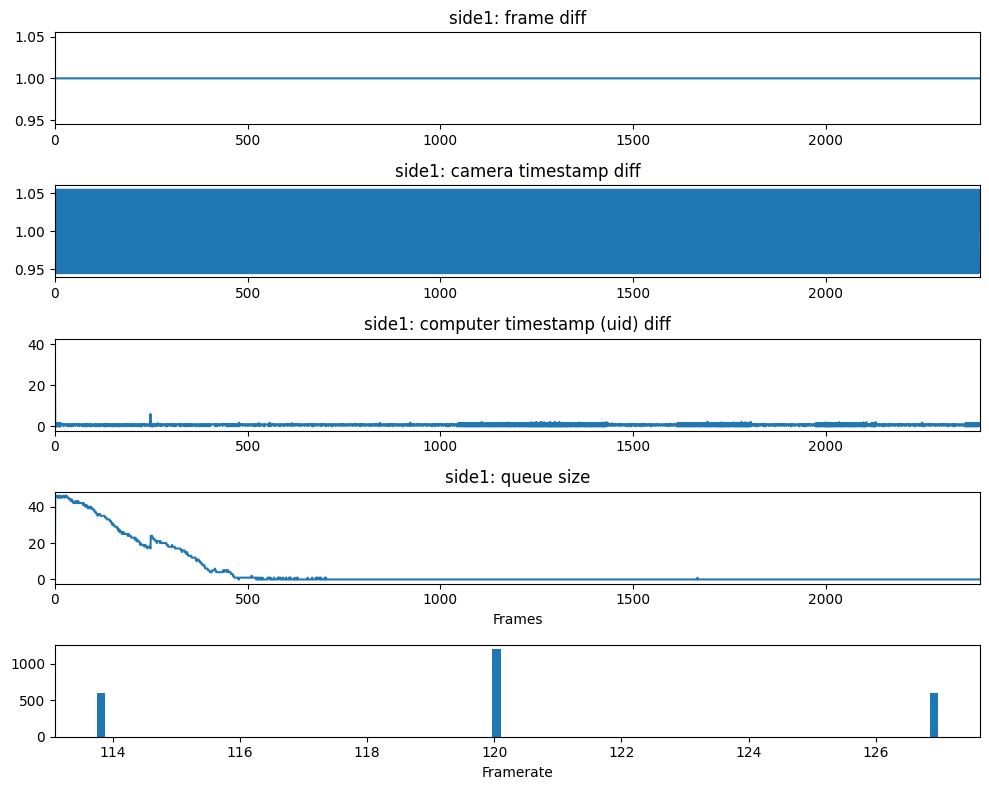

19.99190978
119.99854072970912
top


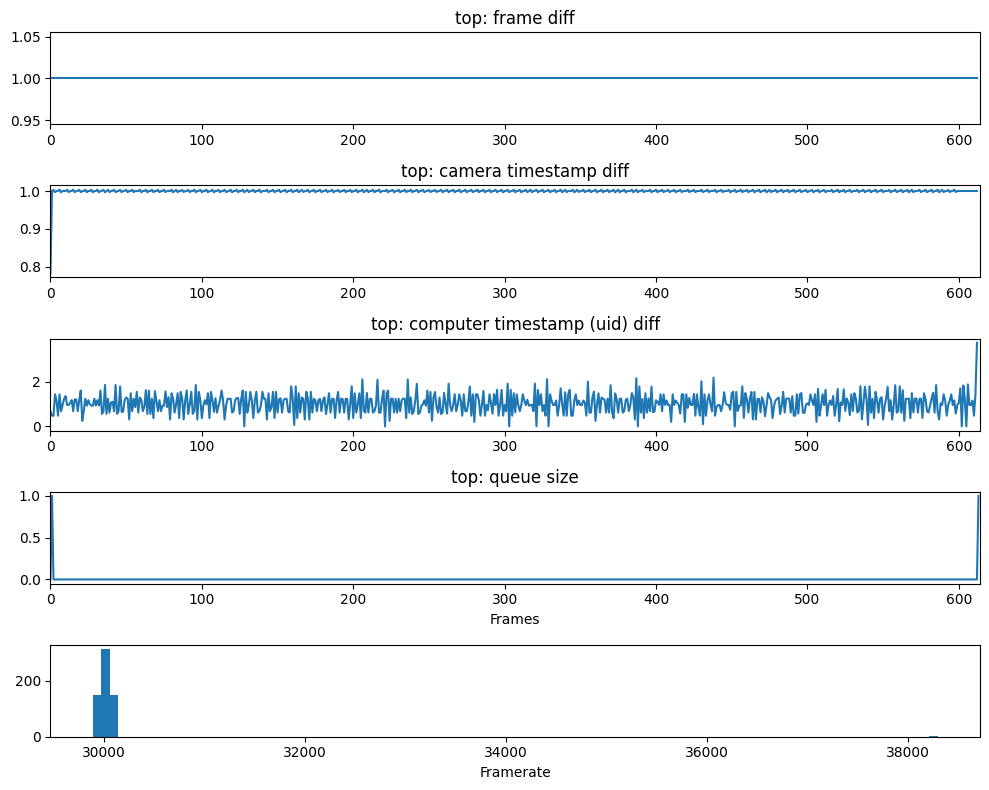

0.020426133000000003
30010.57517837566
bottom


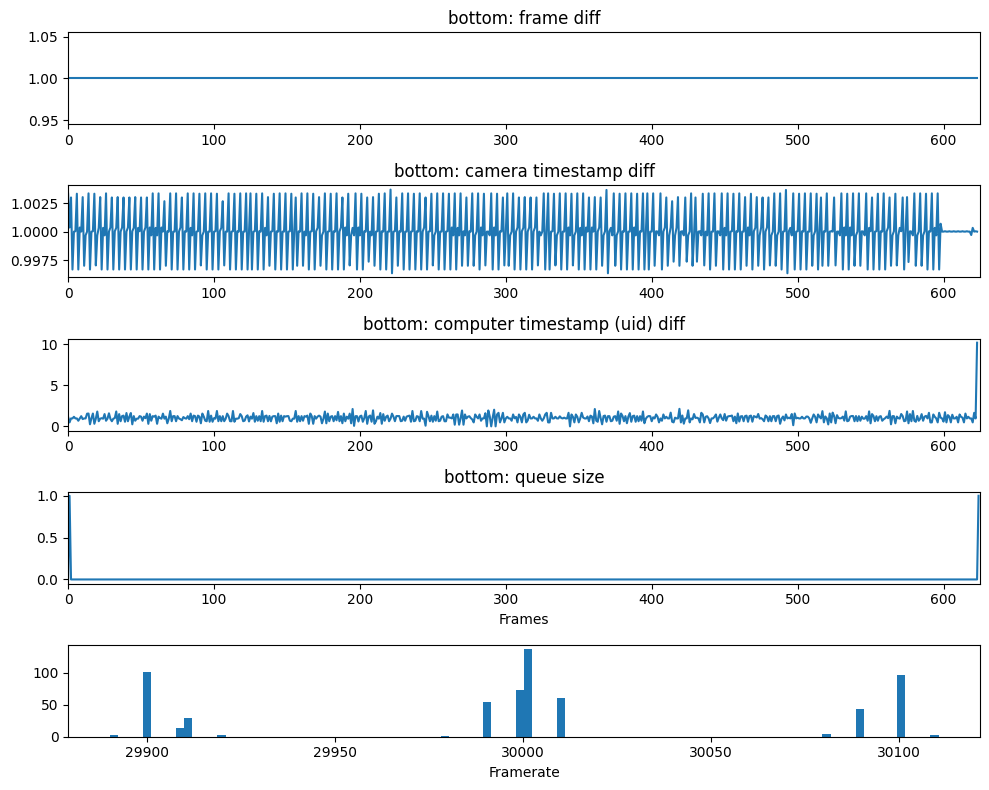

0.020800133000000002
29999.8081743035
azure_top


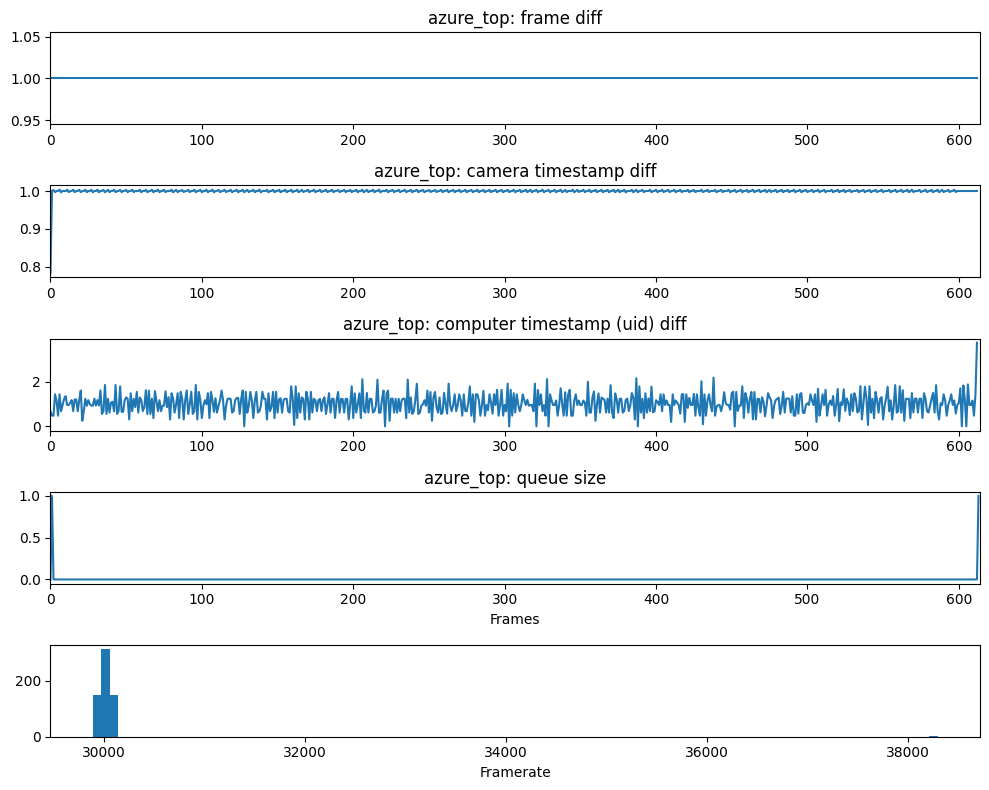

0.020426133000000003
30010.57517837566
azure_bottom


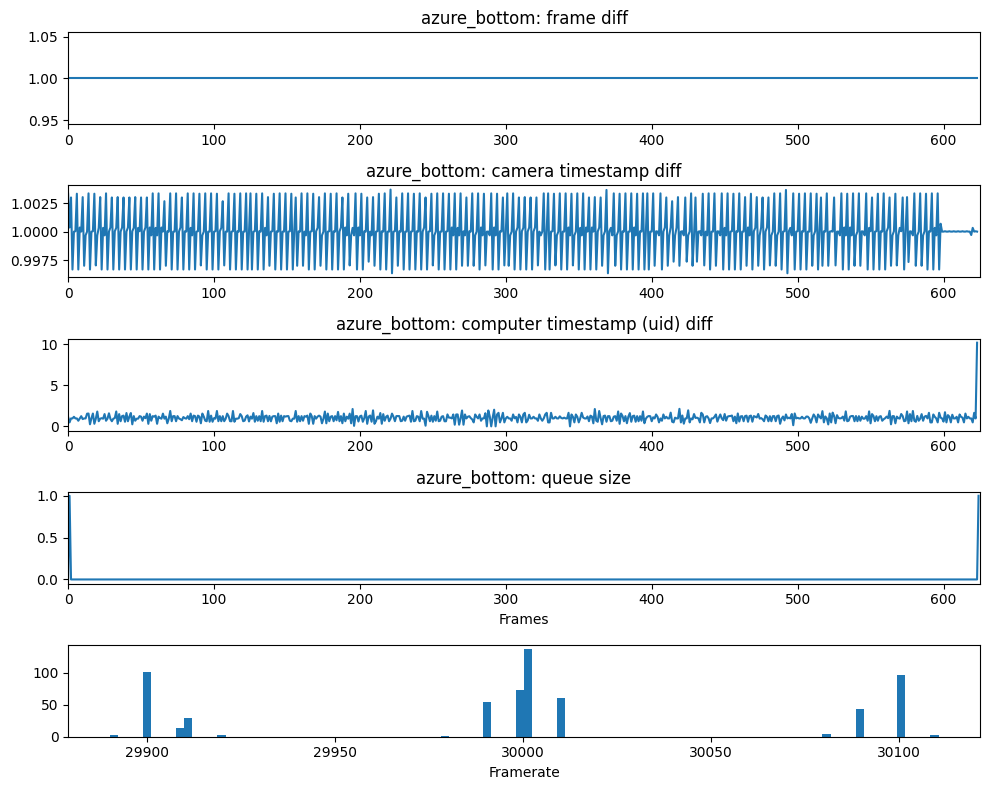

0.020800133000000002
29999.8081743035


In [11]:
for cam in camera_list:
    name = cam['name']
    print(name)
    df = pd.read_csv(glob.glob(str(save_loc)+ f'\*{name}.metadata.csv')[0])
    fig, axs = plt.subplots(ncols = 1, nrows = 5, gridspec_kw= {'height_ratios':[1,1,1,1,1]}, figsize=(10,8))
    nrows = len(df)
    axs[0].set_title(f"{name}: frame diff")
    axs[0].plot(np.diff(df.frame_num.values))
    axs[0].set_xlim([0, len(df)])
    axs[1].set_title(f"{name}: camera timestamp diff")
    axs[1].plot(np.diff(df.frame_timestamp.values) / np.median(np.diff(df.frame_timestamp.values)))
    #axs[1].plot(np.diff(df.frame_timestamp.values))
    axs[1].set_xlim([0, len(df)])
    axs[2].set_title(f"{name}: computer timestamp (uid) diff")
    axs[2].plot(np.diff(df.frame_image_uid.values) / np.median(np.diff(df.frame_image_uid.values)))
    axs[2].set_xlim([0, len(df)])
    axs[3].set_title(f"{name}: queue size")
    axs[3].plot(df.queue_size.values)
    axs[3].set_xlim([0, len(df)])
    axs[3].set_xlabel('Frames')
    axs[4].hist(1/(np.diff(df.frame_timestamp.values)* 1e-9), bins=100);
    axs[4].set_xlabel('Framerate')
    plt.tight_layout()
    plt.show()
    
    time_elapsed = (df.frame_timestamp.values[-1] - df.frame_timestamp.values[0]) * 1e-9
    avg_framerate = np.mean(np.diff(df.frame_timestamp.values))
    print(time_elapsed)
    print(1 / (avg_framerate* 1e-9))